Task 3.

SCARA Manipulator

Streaming output truncated to the last 5000 lines.
-0.0018680662687722283
-0.0018845785772939605
-0.0018845791738959505
-0.0019000597219336335
-0.0019000601855259092
-0.0019145217712780438
-0.0019145222130405593
-0.001927978561049093
-0.0019279789705233252
-0.001948523017416104
-0.0019485241304109113
-0.0019663025229457176
-0.001966300728053594
-0.0019813918782182194
-0.0019813916857821523
-0.001993880821197336
-0.0019938802224288565
-0.0020038564509743395
-0.002003856073526933
-0.0020143365675987512
-0.0020143351021837397
-0.002019640070512141
-0.0020196394501140746
-0.002020077812257104
-0.0020200798143781284
-0.0020159537616684098
-0.0020159535398099893
-0.0020075407500873554
-0.0020075412347483335
-0.001995096130326779
-0.001995096230245519
-0.0019885942651896027
-0.0019885943048895127
-0.001981411153187951
-0.001981411460219129
-0.0019735621329891595
-0.0019735617192693233
-0.001965059627777488
-0.0019650596862416103
-0.0019559170604981357
-0.0019559170237449797
-0.001946145604327

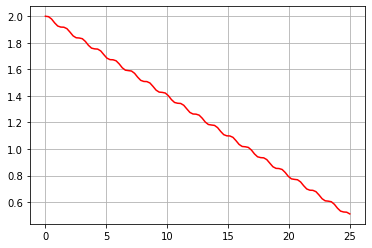

8914


In [13]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import math
import cv2
from cv2 import VideoWriter, VideoWriter_fourcc

# For Arm-1
l1 = 1    #Length in m
r1 = l1/2
R1 = 0.01   #Radius in m
D1 = 500    #Density in kg/m^3
m1 = (math.pi * R1 * R1 * l1) * D1    #Mass in kg
J1 = (1 / 3) * m1 * l1 * l1   #Inertia about end point in kg.m^2
E1 = []

# For Arm2
l2 = 1    #Length in m
r2 = l2/2
R2 = 0.01   #Radius in m
D2 = 1000   #Density in kg/m^3
m2 = (math.pi * R2 * R2 * l2) * D2    #Mass in kg
J2 = (1 / 3) * m2 * l2 * l2   #Inertia about end point in kg.m^2
E2 = []

# For Arm3
l3 = 1    #Length in m
r3 = l3/2
R3 = 0.01   #Radius in m
D3 = 1500   #Density in kg/m^3
m3 = (math.pi * R3 * R3 * l3) * D3    #Mass in kg
J3 = (1 / 3) * m3 * l3 * l3   #Inertia about end point in kg.m^2
E3 = []

T = []
g = 0
I = 0

tprev = 0

def invkin_Scara(x, y, z, d1, d2, d3):
    r = abs((x ** 2 + y ** 2 - d1 ** 2 - d2 ** 2) / (2 * d1 * d2))
    theta2 = np.arctan(np.sqrt(abs(1 - r ** 2)) / r)
    theta1 = np.arctan(y / x) - np.arctan((d2 * np.sin(theta2)) / (d1 + d2 * np.cos(theta2)))
    d = d3 - z
    return theta1, theta2, d


def integrator(E, T):
    n = len(E)
    I = 0
    if n > 30:
        for i in range(n-30, n, 1):
            I = I + E[i]*(T[i] - T[i-1])
    return I


# function that returns dy/dt
def time_der(y, t, m1, m2, m3, l1, l2, l3, r1, r2, r3, J1, J2, J3, g, yda, ydb, I):
    theta1 = y[0]
    theta1d = y[1]
    theta2 = y[2]
    theta2d = y[3]
    d = y[4]
    dd = y[5]

    d_theta1 = yda[0] + ((ydb[0] - yda[0])*t)/50
    d_theta2 = yda[1] + ((ydb[1] - yda[1]) * t) / 50
    d_d = yda[2] + ((ydb[2] - yda[2]) * t) / 50

    alpha = J1 + r1 * r1 * m1 + l1 * l1 * m2 + l1 * l1 * m3
    beta = J2 + J3 + l2 * l2 * m3 + m2 * r2 * r2
    gamma = l1 * l2 * m3 + l1 * r2 * m2

    e1 = d_theta1 - theta1
    E1.append(e1)

    e2 = d_theta2 - theta2
    E2.append(e2)

    e3 = d_d - d
    E3.append(e3)

    T.append(t)

    I1 = integrator(E1, T)
    I2 = integrator(E2, T)
    I3 = integrator(E3, T)
    print(e1)

    u1 = -gamma*np.sin(theta2)*theta2d*theta1d - gamma*np.sin(theta2)*(theta2d + theta1d)*theta2d + 10*e1 - 0.7*I1
    u2 = gamma*np.sin(theta2)*theta1d*theta1d - 20*e2 - 0.2*I2
    u3 = -m3*g + 10*e3 - 0.1*I3

    MM = np.array([[alpha + beta + 2*gamma*np.cos(theta2), beta + 2*gamma*np.cos(theta2), 0],
                   [beta + 2*gamma*np.cos(theta2), beta, 0], [0, 0, m3]])
    C = np.array([[-gamma*np.sin(theta2)*theta2d, -gamma*np.sin(theta2)*(theta2d + theta1d), 0],
                  [gamma*np.sin(theta2)*theta1d, 0, 0],
                  [0, 0, 0]])
    G = np.transpose(np.array([0, 0, m3*g]))
    U = np.transpose(np.array([u1, u2, u3]))
    W = (U - np.matmul(C, np.transpose([theta1d, theta2d, dd])) - G)
    dydt = np.matmul(np.linalg.inv(MM), W)
    yd = np.array([theta1d, dydt[0], theta2d, dydt[1], dd, dydt[2]])
    tprev = t
    return yd


# initial condition
A = [1, 2, 3]
B = [4, 5, 6]

yda = invkin_Scara(A[0], A[1], A[2], l1, l2, 5)
ydb = invkin_Scara(B[0], B[1], B[2], l1, l2, 5)

y0 = np.array([yda[0], 0, yda[1], 0, yda[2], 0])

# time points
t = np.linspace(0, 25, num=100)

# solve ODE
y = odeint(time_der, y0, t, args=(m1, m2, m3, l1, l2, l3, r1, r2, r3, J1, J2, J3, g, yda, ydb, I))
print(yda, ydb)

plt.plot(t, y[:, 4], color='r', label='Phi')

plt.grid()
plt.show()
print(len(T))

Task 4.

PUMA Manipulator

Theta1 =  0.3339468857854696 
 Theta2 = -2.644207591487928 
 Theta3:  2.765209171272065 

Theta1 =  0.1961352164439829 
 Theta2 = -1.674971140289529 
 Theta3:  2.233182293296686 

(0.3339468857854696, -2.644207591487928, 2.765209171272065) (0.1961352164439829, -1.674971140289529, 2.233182293296686)


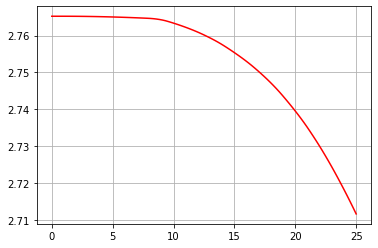

4479


In [21]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import math
import cv2
from cv2 import VideoWriter, VideoWriter_fourcc
import sys

# Arm 1
l1 = 10   #Length in m
r1 = l1/2
R1 = 0.01   #Radius in m
D1 = 500    #Density in kg/m^3
m1 = (np.pi * (R1**2) * l1) * D1    #Mass in kg
J1 = (1 / 3) * m1 * (l1**2)   #Inertia about end point in kg.m^2
E1 = []

# Arm 2
l2 = 10   #Length in m
r2 = l2/2
R2 = 0.01   #Radius in m
D2 = 1000   #Density in kg/m^3
m2 = (np.pi * (R2**2) * l2) * D2    #Mass in kg
J2 = (1 / 3) * m2 * (l2**2)   #Inertia about end point in kg.m^2
E2 = []

# Arm 3
l3 = 10   #Length in m  
r3 = l3/2
R3 = 0.01   #Radius in m
D3 = 1500   #Density in kg/m^3
m3 = (np.pi * (R3 **2) * l3) * D3   #Mass in kg
J3 = (1 / 3) * m3 * (l3**2)   #Inertia about end point in kg.m^2
E3 = []

T = []
g = 9.81
I = 0

tprev = 0

def invkin_Puma(x,y,z,l1,l2,l3):
    theta1 = np.arctan2(y,x) - np.arctan2(l3, np.sqrt(x**2 +y**2+l3**2))
    D = (x**2+y**2+z**2-l2**2-l3**2)/(2*l2*l3)
    if D>1 or D<-1:
        print("outside workspace")
        sys.exit()
    theta3 = np.arctan2(np.sqrt(1-D**2), D)
    theta2 = np.arctan2(z-l1,np.sqrt(x**2+y**2))-np.arctan2(l3*np.sin(theta3),l2+l3*np.cos(theta3))
    print("Theta1 = ", theta1, "\n Theta2 =", theta2,"\n Theta3: ", theta3, "\n")
    return theta1, theta2, theta3


def integrator(E, T):
    n = len(E)
    I = 0
    if n > 30:
        for i in range(n-30, n, 1):
            I = I + E[i]*(T[i] - T[i-1])
    return I

# function for dy/dt
def time_der(y, t, m1, m2, m3, l1, l2, l3, r1, r2, r3, J1, J2, J3, g, yda, ydb, I):
    theta1 = y[0]
    theta1d = y[1]
    theta2 = y[2]
    theta2d = y[3]
    theta3 = y[4]
    theta3d = y[5]

    d_theta1 = yda[0] + ((ydb[0] - yda[0]) * t) / 50
    d_theta2 = yda[1] + ((ydb[1] - yda[1]) * t) / 50
    d_theta3 = yda[2] + ((ydb[2] - yda[2]) * t) / 50

    e1 = d_theta1 - theta1
    E1.append(e1)

    e2 = d_theta2 - theta2
    E2.append(e2)

    e3 = d_theta3 - theta3
    E3.append(e3)

    T.append(t)

    I1 = integrator(E1, T)
    I2 = integrator(E2, T)
    I3 = integrator(E3, T)
    #print(e1, e2, e3)

    a1 = ((l2**2) * m3) + ((r2**2) * m2)
    a2 = ((r3**2) * m3)
    a3 = m3*r3*l2
    b1 = (m2*r2 + m3*l2)*g
    b2 = m3*r3*g
    kp = [1,1,1]
    ki = [1,1,1]

    u1 = kp[0]*e1 + ki[0]*I1
    u2 = b1*np.cos(theta2) + b2*np.cos(theta2 + theta3) + kp[1]*e2 + ki[1]*I2
    u3 = b2*np.cos(theta2 + theta3) + kp[2]*e3 + ki[2]*I3

    M = np.array([[a1*(np.cos(theta2)**2) + a2*(np.cos(theta2+theta3)**2)  + 2*a3*np.cos(theta2)*np.cos(theta2+theta3) + J1, 0, 0],
                   [0, a1 + a2 + 2*a3*np.cos(theta3) + J2, a2 + a3*np.cos(theta3)], 
                   [0, a2 + a3*np.cos(theta3), a3 + J3]])
    C = np.array([[-0.5*a1*np.sin(2*theta2)*theta2d - 0.5*a2*np.sin(2*(theta2+theta3))*(theta2d+theta3d) - a3*np.sin(2*theta2+theta3)*theta2d - a3*np.cos(theta2)*np.sin(theta2+theta3)*theta3d, -0.5*a1*np.sin(2*theta2)*theta1d - 0.5*a2*np.sin(2*(theta2+theta3))*(theta1d) - a3*np.sin(2*theta2+theta3)*theta1d , - 0.5*a2*np.sin(2*(theta2+theta3))*(theta1d) - a3*np.cos(theta2)*np.sin(theta2+theta3)*theta1d],
                  [0.5*a1*np.sin(2*theta2)*theta1d + 0.5*a2*np.sin(2*(theta2+theta3))*(theta1d) + a3*np.sin(2*theta2+theta3)*theta1d, -a3*np.sin(theta3)*theta3d, -a3*np.sin(theta3)*(theta2d+theta3d)],
                  [0.5*a2*np.sin(2*(theta2+theta3))*(theta1d) + a3*np.cos(theta2)*np.sin(theta2+theta3)*theta1d, a3*np.sin(theta3)*theta2d, 0]])
    G = np.transpose(np.array([0, b1*np.cos(theta2) + b2*np.cos(theta2+theta3), b2*np.cos(theta2+theta3)]))
    U = np.transpose(np.array([u1, u2, u3]))
    W = (U - np.matmul(C, np.transpose([theta1d, theta2d, theta3d])) - G)
    dydt = np.matmul(np.linalg.inv(M), W)
    yd = np.array([theta1d, dydt[0], theta2d, dydt[1], theta3d, dydt[2]])
    tprev = t
    return yd

# initial condition
A = [1, 2, 3]
B = [4, 5, 6]

yda = invkin_Puma(A[0], A[1], A[2], l1, l2, l3)
ydb = invkin_Puma(B[0], B[1], B[2], l1, l2, l3)

y0 = np.array([yda[0], 0, yda[1], 0, yda[2], 0])

# time points
t = np.linspace(0, 25, num=100)

# solve ODE
y = odeint(time_der, y0, t, args=(m1, m2, m3, l1, l2, l3, r1, r2, r3, J1, J2, J3, g, yda, ydb, I))
print(yda, ydb)

plt.plot(t, y[:, 4], color='r', label='Phi')

plt.grid()
plt.show()
print(len(T))